In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import scipy.stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import urllib
import requests
import zipfile
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
from sklearn.decomposition import PCA
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from fiona.crs import from_epsg
import os
from astropy.stats import median_absolute_deviation
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import cross_val_score
from factor_analyzer import FactorAnalyzer
from sklearn import  preprocessing
import pysal

Populating the interactive namespace from numpy and matplotlib


C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv('DATA/bk1516.csv')

In [3]:
data.head()

,Unnamed: 0,GEOID,FHVdiff,NYPDviolationDiff,NYPDmisdemeanorDiff,NYPDfelonyDiff,units,C1Diff,C2Diff,Pop_Den_16DIFF,Median_Household_Income_16DIFF,Gini_Index_16DIFF,Ave_Commute_Min_16DIFF,Unemployed_rate_16DIFF,Moved_in_4years_16DIFF,licenseDiff
0,0,36047000100,53734.26569,10,-24,-17,106.0,268.674349,221.228009,-927.32270,16254,-0.0224,-1.119191,0.002828,0.000000,-2
1,1,36047000200,12981.97157,2,-45,-2,NaN,70.153287,61.517968,-2046.26377,13653,-0.0072,0.851351,-0.008858,0.000159,0
2,2,36047000301,50795.12162,-3,16,15,NaN,0.000000,0.000000,3144.94739,10817,0.0052,1.719752,-0.006191,0.003595,0
3,3,36047000501,20603.51739,2,-19,-10,62.0,0.000000,0.000000,-1917.98480,13505,-0.0156,-0.964950,-0.011073,-0.003782,0
4,4,36047000502,23863.10789,4,10,0,NaN,211.354329,195.842370,481.54980,8841,-0.0362,-0.019987,-0.021162,0.009077,-4


In [4]:
data.units = data.units.replace(np.nan,0)

In [5]:
data = data.drop(['Unnamed: 0'],axis=1)

In [6]:
data.head(3)

,GEOID,FHVdiff,NYPDviolationDiff,NYPDmisdemeanorDiff,NYPDfelonyDiff,units,C1Diff,C2Diff,Pop_Den_16DIFF,Median_Household_Income_16DIFF,Gini_Index_16DIFF,Ave_Commute_Min_16DIFF,Unemployed_rate_16DIFF,Moved_in_4years_16DIFF,licenseDiff
0,36047000100,53734.26569,10,-24,-17,106.0,268.674349,221.228009,-927.32270,16254,-0.0224,-1.119191,0.002828,0.000000,-2
1,36047000200,12981.97157,2,-45,-2,0.0,70.153287,61.517968,-2046.26377,13653,-0.0072,0.851351,-0.008858,0.000159,0
2,36047000301,50795.12162,-3,16,15,0.0,0.000000,0.000000,3144.94739,10817,0.0052,1.719752,-0.006191,0.003595,0


In [7]:
TRACT = gpd.GeoDataFrame.from_file('DATA/gz_2010_36_140_00_500k/gz_2010_36_140_00_500k.shp')

In [8]:
TRACT.GEO_ID = TRACT.GEO_ID.str[9:]

In [9]:
data.GEOID = data.GEOID.astype('str')

In [10]:
data = pd.merge(TRACT,data,left_on='GEO_ID',right_on='GEOID')

In [11]:
data.TRACT = data.TRACT.astype('int64')

In [12]:
NTA = pd.read_csv('DATA/2010CensusTract_PUMA_NTA(1).csv')

In [13]:
NTA = NTA[NTA['Borough'] == 'Brooklyn']

In [14]:
data = pd.merge(data,NTA,left_on='TRACT',right_on='2010CensusTract')

In [16]:
data.groupby('PUMA').median()['FHVdiff'][4001]

26933.47539

In [17]:
def median_interpolation(data,columns):
    for column in columns:
        for i in range(len(data.index)):
            if np.isnan(data[column][i]):
                data[column][i] = data.groupby('PUMA').median()[column][data['PUMA'][i]] 
    return data

In [24]:
data.columns[9:23]

Index(['FHVdiff', 'NYPDviolationDiff', 'NYPDmisdemeanorDiff', 'NYPDfelonyDiff',
       'units', 'C1Diff', 'C2Diff', 'Pop_Den_16DIFF',
       'Median_Household_Income_16DIFF', 'Gini_Index_16DIFF',
       'Ave_Commute_Min_16DIFF', 'Unemployed_rate_16DIFF',
       'Moved_in_4years_16DIFF', 'licenseDiff'],
      dtype='object')

In [25]:
data = median_interpolation(data,data.columns[9:23])

In [26]:
data.isnull().sum()

GEO_ID                            0
STATE                             0
COUNTY                            0
TRACT                             0
NAME                              0
LSAD                              0
CENSUSAREA                        0
geometry                          0
GEOID                             0
FHVdiff                           0
NYPDviolationDiff                 0
NYPDmisdemeanorDiff               0
NYPDfelonyDiff                    0
units                             0
C1Diff                            0
C2Diff                            0
Pop_Den_16DIFF                    0
Median_Household_Income_16DIFF    0
Gini_Index_16DIFF                 0
Ave_Commute_Min_16DIFF            0
Unemployed_rate_16DIFF            0
Moved_in_4years_16DIFF            0
licenseDiff                       0
Borough                           0
2010CensusTract                   0
PUMA                              0
NTA_Code                          0
NTA_Name                    

## Normalization

In [27]:
data.columns[9:23]

Index(['FHVdiff', 'NYPDviolationDiff', 'NYPDmisdemeanorDiff', 'NYPDfelonyDiff',
       'units', 'C1Diff', 'C2Diff', 'Pop_Den_16DIFF',
       'Median_Household_Income_16DIFF', 'Gini_Index_16DIFF',
       'Ave_Commute_Min_16DIFF', 'Unemployed_rate_16DIFF',
       'Moved_in_4years_16DIFF', 'licenseDiff'],
      dtype='object')

In [28]:
def norm(data,columns):
    for x in columns:
        data[x] = (data[x]-np.min(data[x]))/(np.max(data[x])-np.min(data[x]))
    return data

In [29]:
data = norm(data,data.columns[9:23])

In [30]:
data.head(1)

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geometry,GEOID,FHVdiff,NYPDviolationDiff,NYPDmisdemeanorDiff,NYPDfelonyDiff,units,C1Diff,C2Diff,Pop_Den_16DIFF,Median_Household_Income_16DIFF,Gini_Index_16DIFF,Ave_Commute_Min_16DIFF,Unemployed_rate_16DIFF,Moved_in_4years_16DIFF,licenseDiff,Borough,2010CensusTract,PUMA,NTA_Code,NTA_Name
0,36047010400,36,047,10400,104,Tract,0.059,"POLYGON ((-74.01115399999999 40.637404, -74.01...",36047010400,0.021357,0.633803,0.661538,0.735294,0.0,0.146359,0.277246,0.416344,0.512024,0.420905,0.4917,0.373334,0.50664,0.846154,Brooklyn,10400,4012,BK34,Sunset Park East


## Outliers

In [31]:

def clean(data,columns):
    for x in columns:
        #data= data[(np.abs(data[x]-np.median(data[x]))/(np.median(np.abs(data[x]-np.median(data[x])))/0.6745)) < 2.24]
        data = data[(data[x]<np.mean(data[x])+4*np.std(data[x]))&(data[x]>np.mean(data[x])-4*np.std(data[x]))]
    return data

In [32]:
data = clean(data,data.columns[9:23])

In [33]:
data.shape

(697, 28)

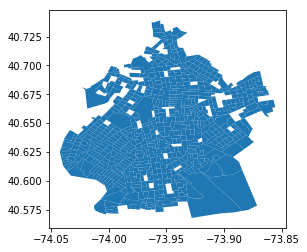

In [34]:
data.plot()

In [35]:
data.columns[9:23]

Index(['FHVdiff', 'NYPDviolationDiff', 'NYPDmisdemeanorDiff', 'NYPDfelonyDiff',
       'units', 'C1Diff', 'C2Diff', 'Pop_Den_16DIFF',
       'Median_Household_Income_16DIFF', 'Gini_Index_16DIFF',
       'Ave_Commute_Min_16DIFF', 'Unemployed_rate_16DIFF',
       'Moved_in_4years_16DIFF', 'licenseDiff'],
      dtype='object')

## PCA

In [36]:
X_num = data[data.columns[9:23]].drop(['units', 'C1Diff', 'C2Diff'],axis=1)
pca = PCA(0.90)
Xproj = pca.fit_transform(X_num)

In [37]:
pca.explained_variance_ratio_

array([ 0.21314695,  0.15565868,  0.13817229,  0.12700581,  0.09367777,
        0.09097759,  0.06723054,  0.04819477])

In [38]:
components_explanation = pd.DataFrame(pca.components_,columns = X_num.columns)
components_explanation

,FHVdiff,NYPDviolationDiff,NYPDmisdemeanorDiff,NYPDfelonyDiff,Pop_Den_16DIFF,Median_Household_Income_16DIFF,Gini_Index_16DIFF,Ave_Commute_Min_16DIFF,Unemployed_rate_16DIFF,Moved_in_4years_16DIFF,licenseDiff
0,0.028093,0.068579,0.635877,0.698005,0.008364,0.076804,-0.009742,-0.103286,-0.073201,-0.009154,0.284223
1,-0.013016,-0.615021,-0.126723,-0.129761,0.335607,0.144291,-0.044817,-0.064409,-0.034641,0.002963,0.669228
2,0.027984,-0.315769,0.129874,0.116727,0.608387,0.305750,-0.114676,-0.027061,-0.027109,-0.001539,-0.625121
3,-0.076413,-0.711718,0.119985,0.137788,-0.495497,-0.327795,0.123876,0.094752,0.073223,0.029812,-0.265886
4,0.081724,-0.084412,-0.046755,-0.048288,-0.500040,0.687602,-0.395193,-0.013329,-0.318113,0.000609,-0.035909
5,-0.002898,-0.026118,-0.051254,-0.052928,-0.081821,-0.058897,0.039019,-0.987387,0.025152,0.000634,-0.081414
6,0.050765,-0.006362,-0.009626,-0.041509,0.099166,-0.310698,0.108019,-0.003320,-0.934777,-0.047032,-0.038735
7,0.349270,-0.022155,-0.026315,-0.011516,-0.066353,0.385609,0.850191,0.018272,-0.016500,-0.001901,-0.012800


## FA

In [39]:
fa = FactorAnalyzer()

In [40]:
fa.analyze(X_num,5,rotation='varimax')

In [41]:
fa.get_communalities()

,Communalities
FHVdiff,0.106010
NYPDviolationDiff,0.061073
NYPDmisdemeanorDiff,0.798952
NYPDfelonyDiff,0.803219
Pop_Den_16DIFF,0.107393
Median_Household_Income_16DIFF,0.409195
Gini_Index_16DIFF,0.250129
Ave_Commute_Min_16DIFF,0.024140
Unemployed_rate_16DIFF,0.057464
Moved_in_4years_16DIFF,0.031677


In [42]:
fa.loadings

,Factor1,Factor2,Factor3,Factor4,Factor5
FHVdiff,-0.013484,-0.039524,-0.317200,-0.060420,0.0
NYPDviolationDiff,-0.053916,0.023053,-0.167673,0.171816,0.0
NYPDmisdemeanorDiff,-0.882171,-0.018092,-0.094488,-0.107099,0.0
NYPDfelonyDiff,-0.886250,-0.006024,-0.068858,-0.114029,0.0
Pop_Den_16DIFF,0.052838,-0.138090,-0.051771,-0.287840,0.0
Median_Household_Income_16DIFF,-0.001541,-0.556508,-0.221890,-0.224180,0.0
Gini_Index_16DIFF,-0.001528,0.498549,-0.033039,-0.021990,0.0
Ave_Commute_Min_16DIFF,0.065510,0.002814,0.042438,0.134310,0.0
Unemployed_rate_16DIFF,0.057497,0.130466,0.191718,0.019511,0.0
Moved_in_4years_16DIFF,0.004592,-0.003877,0.177674,0.008540,0.0


In [43]:
fa.get_factor_variance()

,Factor1,Factor2,Factor3,Factor4,Factor5
SS Loadings,1.585519,0.597055,0.265536,0.241697,0.000000
Proportion Var,0.144138,0.054278,0.024140,0.021972,0.000000
Cumulative Var,0.144138,0.198416,0.222555,0.244528,0.244528


In [44]:
fa.loadings[np.abs(fa.loadings['Factor1'])>0.5]['Factor1']

NYPDmisdemeanorDiff   -0.882171
NYPDfelonyDiff        -0.886250
Name: Factor1, dtype: float64

In [45]:
for column in fa.loadings:
    print(column+':\n')
    print(fa.loadings[np.abs(fa.loadings[column])>0.5][column])
    print('\n')

Factor1:

NYPDmisdemeanorDiff   -0.882171
NYPDfelonyDiff        -0.886250
Name: Factor1, dtype: float64


Factor2:

Median_Household_Income_16DIFF   -0.556508
Name: Factor2, dtype: float64


Factor3:

Series([], Name: Factor3, dtype: float64)


Factor4:

Series([], Name: Factor4, dtype: float64)


Factor5:

Series([], Name: Factor5, dtype: float64)




## Factor 1: Crime
## Factor 2: Income intergration and poverty level
## Factor 3: Traffic convenience
## Factor 4: New population

In [46]:
X_num.head(1)

,FHVdiff,NYPDviolationDiff,NYPDmisdemeanorDiff,NYPDfelonyDiff,Pop_Den_16DIFF,Median_Household_Income_16DIFF,Gini_Index_16DIFF,Ave_Commute_Min_16DIFF,Unemployed_rate_16DIFF,Moved_in_4years_16DIFF,licenseDiff
0,0.021357,0.633803,0.661538,0.735294,0.416344,0.512024,0.420905,0.4917,0.373334,0.50664,0.846154


In [47]:
X_num.to_csv('X_num.csv')

In [48]:
X_num1 = pd.read_csv('X_num3.csv')

In [49]:
data = data.drop(list(X_num.columns),axis=1)

In [50]:
data.head(1)

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geometry,GEOID,units,C1Diff,C2Diff,Borough,2010CensusTract,PUMA,NTA_Code,NTA_Name
0,36047010400,36,047,10400,104,Tract,0.059,"POLYGON ((-74.01115399999999 40.637404, -74.01...",36047010400,0.0,0.146359,0.277246,Brooklyn,10400,4012,BK34,Sunset Park East


In [51]:
data.index = range(len(data.index))

In [258]:
#X_num1.columns = ['Crime','Income intergration and poverty level','Traffic convenience','New population']

In [52]:
for column in X_num1.columns:
    data[column] = X_num1[column]

In [53]:
columns = []
for column in data.columns:
    column = column.replace(' ','_' )
    columns.append(column)

In [54]:
data.columns = columns

In [55]:
data.head(1)

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geometry,GEOID,units,C1Diff,C2Diff,Borough,2010CensusTract,PUMA,NTA_Code,NTA_Name,FAC1_1,FAC2_1,FAC3_1,FAC4_1,FAC5_1
0,36047010400,36,047,10400,104,Tract,0.059,"POLYGON ((-74.01115399999999 40.637404, -74.01...",36047010400,0.0,0.146359,0.277246,Brooklyn,10400,4012,BK34,Sunset Park East,2.155093,-0.360688,-0.714466,0.065551,-2.27309


In [64]:
data.units[data.units > 0] =1

C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [102]:
from patsy import dmatrices

In [103]:
y, X = dmatrices('C1Diff~C(units)+'+'+'.join(data.columns[-5:]),data,return_type='dataframe')
y = np.ravel(y)

In [112]:
data['units'] = X['C(units)[T.1.0]']

In [113]:
'C1Diff~'+'+'.join(data.columns[-5:])

'C1Diff~FAC1_1+FAC2_1+FAC3_1+FAC4_1+FAC5_1'

In [114]:
lm_no_units = smf.ols(formula='C1Diff~'+'+'.join(data.columns[-5:])
             ,data=data).fit()
lm_no_units.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 C1Diff   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     14.70
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           1.03e-13
Time:                        21:23:35   Log-Likelihood:                 647.63
No. Observations:                 697   AIC:                            -1283.
Df Residuals:                     691   BIC:                            -1256.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2165      0.004     59.564      0.000       0.209       0.224
FAC1_1         0.0105      0.004      2.885      0.004       0.003       0.018
FAC2_1        -0.0046      0.004     -1.254      0.210      -0.012       0.003
FAC3_1         0.0236      0.004      6.498      0.000       0.016       0.031
FAC4_1        -0.0049      0.004     -1.343      0.180      -0.012       0.002
FAC5_1         0.0161      0.004      4.422      0.000       0.009       0.023
==============================================================================
Omnibus:                      114.418   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.760
Skew:                           0.982   Prob(JB):                     1.27e-45
Kurtosis:                       4.805   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
lm_with_units = smf.ols(formula='C1Diff~C(units)+'+'+'.join(data.columns[-5:])
             ,data=data).fit()
lm_with_units.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 C1Diff   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     12.23
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           4.21e-13
Time:                        21:23:38   Log-Likelihood:                 647.64
No. Observations:                 697   AIC:                            -1281.
Df Residuals:                     690   BIC:                            -1249.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2165      0.004     58.711      0.000       0.209       0.224
C(units)[T.1.0]     0.0019      0.025      0.079      0.937      -0.046       0.050
FAC1_1              0.0105      0.004      2.881      0.004       0.003       0.018
FAC2_1             -0.0045      0.004     -1.246      0.213      -0.012       0.003
FAC3_1              0.0236      0.004      6.406      0.000       0.016       0.031
FAC4_1             -0.0049      0.004     -1.329      0.184      -0.012       0.002
FAC5_1              0.0160      0.004      4.280      0.000       0.009       0.023
==============================================================================
Omnibus:                      114.438   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.839
Skew:                           0.982   Prob(JB):                     1.22e-45
Kurtosis:                       4.806   Cond. No.                         6.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [116]:
anova = sm.stats.anova_lm(lm_no_units,lm_with_units)
anova

C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,691.0,6.363386,0.0,NaN,NaN,NaN
1,690.0,6.363328,1.0,0.000057,0.006212,0.937201


In [117]:
lm1_no_units = smf.ols(formula='C2Diff~'+'+'.join(data.columns[-5:])
             ,data=data).fit()
lm1_no_units.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 C2Diff   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     17.58
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           2.07e-16
Time:                        21:23:40   Log-Likelihood:                 248.60
No. Observations:                 697   AIC:                            -485.2
Df Residuals:                     691   BIC:                            -457.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2853      0.006     44.283      0.000       0.273       0.298
FAC1_1        -0.0121      0.006     -1.871      0.062      -0.025       0.001
FAC2_1         0.0096      0.006      1.495      0.135      -0.003       0.022
FAC3_1         0.0393      0.006      6.095      0.000       0.027       0.052
FAC4_1        -0.0311      0.006     -4.819      0.000      -0.044      -0.018
FAC5_1         0.0301      0.006      4.666      0.000       0.017       0.043
==============================================================================
Omnibus:                      109.586   Durbin-Watson:                   1.350
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.897
Skew:                           1.100   Prob(JB):                     1.15e-35
Kurtosis:                       3.838   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
lm1_with_units = smf.ols(formula='C2Diff~C(units)+'+'+'.join(data.columns[-5:])
             ,data=data).fit()
lm1_with_units.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 C2Diff   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     14.73
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           7.15e-16
Time:                        21:23:41   Log-Likelihood:                 248.87
No. Observations:                 697   AIC:                            -483.7
Df Residuals:                     690   BIC:                            -451.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2861      0.007     43.794      0.000       0.273       0.299
C(units)[T.1.0]    -0.0320      0.044     -0.733      0.464      -0.118       0.054
FAC1_1             -0.0120      0.006     -1.853      0.064      -0.025       0.001
FAC2_1              0.0093      0.006      1.445      0.149      -0.003       0.022
FAC3_1              0.0400      0.007      6.134      0.000       0.027       0.053
FAC4_1             -0.0315      0.006     -4.865      0.000      -0.044      -0.019
FAC5_1              0.0312      0.007      4.707      0.000       0.018       0.044
==============================================================================
Omnibus:                      111.363   Durbin-Watson:                   1.349
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.661
Skew:                           1.110   Prob(JB):                     1.76e-36
Kurtosis:                       3.863   Cond. No.                         6.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
anova = sm.stats.anova_lm(lm1_no_units,lm1_with_units)
anova

C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,691.0,19.996519,0.0,NaN,NaN,NaN
1,690.0,19.980948,1.0,0.015571,0.537712,0.463632


## Spatial regression

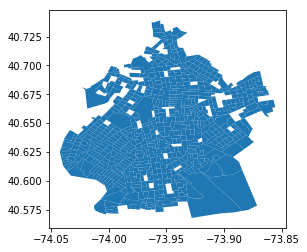

In [120]:
data.plot()

In [121]:
W = pysal.weights.Queen.from_dataframe(data)

In [122]:
W.islands

[]

In [123]:
data = data.drop(W.islands)

In [124]:
from pysal.spreg import ols

In [125]:
W1 = pysal.weights.Queen.from_dataframe(data)

In [126]:
'C1Diff~'+'+'.join(data.columns[-5:])

'C1Diff~FAC1_1+FAC2_1+FAC3_1+FAC4_1+FAC5_1'

In [127]:
y = np.array(data['C1Diff'])

In [128]:
y.shape = (len(y),1)

In [129]:
X = np.array(data[list(data.columns[-5:])+['units']]).T

In [130]:
X = X.T

In [131]:
ls = ols.OLS(y, X, name_y = 'C1Diff', name_x = list(data.columns[-5:])+['units'], name_ds = 'data')
print(ls.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :        data
Weights matrix      :        None
Dependent Variable  :      C1Diff                Number of Observations:         697
Mean dependent var  :      0.2165                Number of Variables   :           7
S.D. dependent var  :      0.1006                Degrees of Freedom    :         690
R-squared           :      0.0961
Adjusted R-squared  :      0.0883
Sum squared residual:       6.363                F-statistic           :     12.2307
Sigma-square        :       0.009                Prob(F-statistic)     :    4.21e-13
S.E. of regression  :       0.096                Log likelihood        :     647.637
Sigma-square ML     :       0.009                Akaike info criterion :   -1281.275
S.E of regression ML:      0.0955                Schwarz criterion     :   -1249.447

-----------------------------------------------------------------------------

In [132]:
pysal.Moran(ls.u, W1, two_tailed=False)

In [133]:
mi = pysal.Moran(ls.u, W1, two_tailed=False)
print('Observed I:', mi.I, '\nExpected I:', mi.EI, '\n   p-value:', mi.p_norm)

Observed I: 0.527729121559 
Expected I: -0.0014367816091954023 
   p-value: 0.0


In [134]:
from pysal.spreg import ml_lag, ml_error

In [135]:
spat_err = ml_lag.ML_Lag(y, X, W1, 
                             name_y = 'C1Diff', name_x = list(data.columns[-5:])+['units'], 
                             name_w='W1', name_ds='data')
print(spat_err.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :        data
Weights matrix      :          W1
Dependent Variable  :      C1Diff                Number of Observations:         697
Mean dependent var  :      0.2165                Number of Variables   :           8
S.D. dependent var  :      0.1006                Degrees of Freedom    :         689
Pseudo R-squared    :      0.6501
Spatial Pseudo R-squared:  0.1044
Sigma-square ML     :       0.004                Log likelihood        :     898.420
S.E of regression   :       0.061                Akaike info criterion :   -1780.840
                                                 Schwarz criterion     :   -1744.465

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\optimize\_minimize.py:600: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


In [136]:
spat_err.pr2

0.650136360474926

In [137]:
spat_err.pr2_e

0.10440581407170173

In [89]:
y = np.array(data['C2Diff'])

In [90]:
y.shape = (len(y),1)

In [91]:
X = np.array(data[list(data.columns[-5:])+['units']]).T

In [92]:
X = X.T

In [94]:
ls = ols.OLS(y, X, name_y = 'C2Diff', name_x = list(data.columns[-5:])+['units'], name_ds = 'data')
print(ls.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :        data
Weights matrix      :        None
Dependent Variable  :      C2Diff                Number of Observations:         697
Mean dependent var  :      0.2853                Number of Variables   :           7
S.D. dependent var  :      0.1800                Degrees of Freedom    :         690
R-squared           :      0.1135
Adjusted R-squared  :      0.1058
Sum squared residual:      19.981                F-statistic           :     14.7264
Sigma-square        :       0.029                Prob(F-statistic)     :   7.146e-16
S.E. of regression  :       0.170                Log likelihood        :     248.874
Sigma-square ML     :       0.029                Akaike info criterion :    -483.748
S.E of regression ML:      0.1693                Schwarz criterion     :    -451.920

-----------------------------------------------------------------------------

In [95]:
pysal.Moran(ls.u, W1, two_tailed=False)

In [96]:
mi = pysal.Moran(ls.u, W1, two_tailed=False)
print('Observed I:', mi.I, '\nExpected I:', mi.EI, '\n   p-value:', mi.p_norm)

Observed I: 0.66224656934 
Expected I: -0.0014367816091954023 
   p-value: 0.0


In [97]:
from pysal.spreg import ml_lag, ml_error

In [144]:
X[:,:5]

(697, 5)

In [161]:
spat_err0 = ml_lag.ML_Lag(y, X[:,:5], W1, 
                             name_y = 'C2Diff', name_x = list(data.columns[-5:]), 
                             name_w='W1', name_ds='data')
print(spat_err0.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :        data
Weights matrix      :          W1
Dependent Variable  :      C2Diff                Number of Observations:         697
Mean dependent var  :      0.2165                Number of Variables   :           7
S.D. dependent var  :      0.1006                Degrees of Freedom    :         690
Pseudo R-squared    :      0.6440
Spatial Pseudo R-squared:  0.2402
Sigma-square ML     :       0.004                Log likelihood        :     894.803
S.E of regression   :       0.062                Akaike info criterion :   -1775.606
                                                 Schwarz criterion     :   -1743.778

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\optimize\_minimize.py:600: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


In [162]:
spat_err = ml_lag.ML_Lag(y, X, W1, 
                             name_y = 'C2Diff', name_x = list(data.columns[-5:])+['units'], 
                             name_w='W1', name_ds='data')
print(spat_err.summary)

C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\optimize\_minimize.py:600: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :        data
Weights matrix      :          W1
Dependent Variable  :      C2Diff                Number of Observations:         697
Mean dependent var  :      0.2165                Number of Variables   :           8
S.D. dependent var  :      0.1006                Degrees of Freedom    :         689
Pseudo R-squared    :      0.6501
Spatial Pseudo R-squared:  0.1044
Sigma-square ML     :       0.004                Log likelihood        :     898.420
S.E of regression   :       0.061                Akaike info criterion :   -1780.840
                                                 Schwarz criterion     :   -1744.465

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [163]:
spat_err.pr2

0.650136360474926

In [164]:
spat_err.pr2_e

0.10440581407170173